In [22]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt 
import time
import gymnasium as gym
from gymnasium import spaces
from gymnasium.spaces import Box,Discrete



pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  

In [106]:
class Game(gym.Env):
    
    #setup our enviroment
    def __init__(self):
        #setup spaces
        self.observation_space = Box(low=0,high=255,shape=(1,83,100),dtype=np.uint8)
        self.action_space = Discrete(2)
        
        #define extraction parameters for the game
        self.cap = mss()
        self.game_location = {'top':120,'left':0,'width':450,'height':250}
        self.done_location = {'top':170,'left':100,'width':470,'height':50}
    
    #This is called to do something in the game
    def step(self,action):
        #action key-0 =space,1= down,2=NOOP
        action_map = {
            0:'space',
#             1:'down',
            1:'no_op'
        }
        
        #check and execute action if not NOOP
        if action !=1:
            pydirectinput.press(action_map[action])
        
        #check wheter the game is done
        done,done_cap= self.get_done()
        
        #Get the next observation/Frame of the game
        new_observation = self.get_observation()
        
        #reward the AI for staying alive
        reward = 2
        
        #info dict required parameter by openai gym library
        info = {}
        truncated = False
        #passing empty as I have no use of it for now
         
        return new_observation,reward,done,truncated,info
        
    
    #Visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    #This closes the game visualization
    def close(self):
        cv2.destroyAllWindows()
    
    #Restart the game
    def reset(self, seed=None, options=None):
        time.sleep(1)
        pydirectinput.click(x=150,y=150)
        pydirectinput.press('space')
         #info dict required parameter by openai gym library
        info = {} #passing empty as I have no use of it for now
        return self.get_observation(),info
    
    #gets the Frame from the game
    def get_observation(self):
        #get screen capture
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        #convert to gray scale
        gray = cv2.cvtColor(raw,cv2.COLOR_BGR2GRAY)
        #resize
        resized = cv2.resize(gray,(100,83))
        #add channels first
        channel = np.reshape(resized,(1,83,100))
        return channel
    
    #gets the done text
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3].astype(np.uint8)
        done_strings = ['GAME','GAHE','GARN']
        
        #Apply OCR
        done=False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done,done_cap

### Testing the env

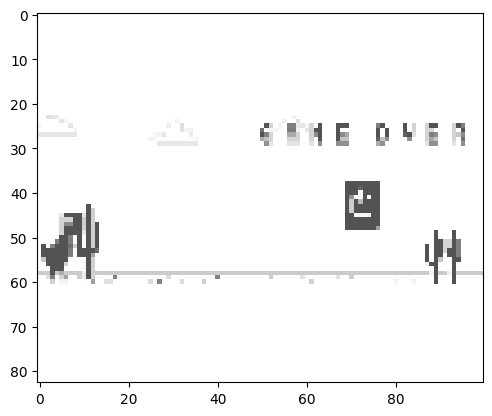

True


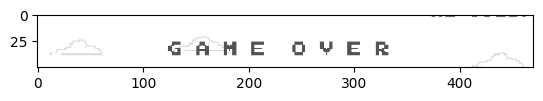

In [107]:
env = Game()
# env.reset()
plt.imshow(cv2.cvtColor(env.get_observation()[0],cv2.COLOR_BGR2RGB))
plt.show()
done,done_cap = env.get_done()
print(done)
plt.imshow(cv2.cvtColor(done_cap,cv2.COLOR_BGR2RGB))
plt.show()


In [96]:
# Loop through each frame in the game
for step in range(5): 
    # Start the game to begin with 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        state, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    
    print(f'Total Reward for Try {step} is: {total_reward}')

ValueError: too many values to unpack (expected 4)

### Trainning the RL model

In [108]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [100]:
env = Game()
env_checker.check_env(env)

In [109]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [110]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [111]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [112]:
from stable_baselines3 import DQN

In [115]:
model = DQN('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, buffer_size=400000,learning_starts=50)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [117]:
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 64.2     |
|    ep_rew_mean      | 128      |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3        |
|    time_elapsed     | 76       |
|    total_timesteps  | 257      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00505  |
|    n_updates        | 52       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.9     |
|    ep_rew_mean      | 99.8     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3        |
|    time_elapsed     | 116      |
|    total_timesteps  | 399      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00013

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 74.5     |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 3        |
|    time_elapsed     | 768      |
|    total_timesteps  | 2532     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.69e-05 |
|    n_updates        | 620      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.9     |
|    ep_rew_mean      | 75.8     |
|    exploration_rate | 0.974    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 3        |
|    time_elapsed     | 829      |
|    total_timesteps  | 2730     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.01e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42       |
|    ep_rew_mean      | 84       |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 3        |
|    time_elapsed     | 1612     |
|    total_timesteps  | 5388     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.7e-07  |
|    n_updates        | 1334     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.3     |
|    ep_rew_mean      | 82.6     |
|    exploration_rate | 0.947    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 3        |
|    time_elapsed     | 1664     |
|    total_timesteps  | 5555     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | 76.7     |
|    exploration_rate | 0.925    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 3        |
|    time_elapsed     | 2366     |
|    total_timesteps  | 7874     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.95e-06 |
|    n_updates        | 1956     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.7     |
|    ep_rew_mean      | 79.4     |
|    exploration_rate | 0.923    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 3        |
|    time_elapsed     | 2443     |
|    total_timesteps  | 8134     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.8     |
|    ep_rew_mean      | 93.6     |
|    exploration_rate | 0.895    |
| time/               |          |
|    episodes         | 260      |
|    fps              | 3        |
|    time_elapsed     | 3285     |
|    total_timesteps  | 11045    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0896   |
|    n_updates        | 2749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.4     |
|    ep_rew_mean      | 90.8     |
|    exploration_rate | 0.894    |
| time/               |          |
|    episodes         | 264      |
|    fps              | 3        |
|    time_elapsed     | 3318     |
|    total_timesteps  | 11148    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0048   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 51.3     |
|    ep_rew_mean      | 103      |
|    exploration_rate | 0.865    |
| time/               |          |
|    episodes         | 324      |
|    fps              | 3        |
|    time_elapsed     | 4208     |
|    total_timesteps  | 14215    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00415  |
|    n_updates        | 3541     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 51       |
|    ep_rew_mean      | 102      |
|    exploration_rate | 0.863    |
| time/               |          |
|    episodes         | 328      |
|    fps              | 3        |
|    time_elapsed     | 4253     |
|    total_timesteps  | 14374    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00458  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.9     |
|    ep_rew_mean      | 95.8     |
|    exploration_rate | 0.836    |
| time/               |          |
|    episodes         | 388      |
|    fps              | 3        |
|    time_elapsed     | 5098     |
|    total_timesteps  | 17262    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0352   |
|    n_updates        | 4303     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.6     |
|    ep_rew_mean      | 95.2     |
|    exploration_rate | 0.834    |
| time/               |          |
|    episodes         | 392      |
|    fps              | 3        |
|    time_elapsed     | 5168     |
|    total_timesteps  | 17505    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00072  |
|    n_updates      

KeyboardInterrupt: 